In [1]:
## Important Options:
run_epochs = 300
run_model_type = "full_y_CVAE"

run_save_folder = "../../outputs/experiments_test/freyfaces/cvae/" 
run_read_data_folder = "../../data/examples_frey_faces/corrupt_level_35_percent/run_1/" # 1 2 3
trust_set_name = "50_samples_per_class" # 5; 10; 25, 50;


In [2]:
ls ../../outputs

experiments_test/


In [3]:
%run ../repair_syserr_models/main.py \
    --cuda-on \
    --save-on \
    --output-folder {run_save_folder} \
    --verbose-metrics-epoch \
    --model-type {run_model_type} \
    --number-epochs {run_epochs} \
    --dataset-folder {run_read_data_folder} \
    --kl-anneal \
    --kl-anneal-start 0.0 \
    --kl-anneal-stop 1.0 \
    --kl-anneal-ratio 0.2 \
    --kl-anneal-delay-epochs 10 \
    --fixed-prior-zy1-sigma 0.2 \
    --use-q-z-y \
    --trust-set-name {trust_set_name}


Namespace(activation='relu', batch_size=128, cuda_on=True, data_folder='../../data/examples_frey_faces/corrupt_level_35_percent/run_1/', dist_corr_reg=False, dist_corr_reg_coeff=1.0, embedding_size=50, fixed_prior_z_clean=1.0, fixed_prior_z_dirty=5.0, fixed_prior_zy0_sigma=5.0, fixed_prior_zy1_sigma=0.2, kl_anneal=True, kl_anneal_cycles=1, kl_anneal_delay_epochs=10, kl_anneal_ratio=0.2, kl_anneal_start=0.0, kl_anneal_stop=1.0, kl_beta_const=1.0, l2_reg=0.0, latent_dim=15, layer_size=400, learn_z_given_y_priors=False, load_model=False, load_model_path=None, log_interval=50, lr=0.001, mean_eps_z_in=0.0, model_type='full_y_CVAE', number_epochs=300, output_folder='../../outputs/experiments_test/freyfaces/cvae/', q_y_x_coeff=1.0, qy_sup_weights=None, reg_delay_n_epochs=5, reg_schedule_ratio=0.5, save_on=True, semi_supervise=False, sigma_eps_z_in=0.1, size_input=560, size_output=560, sup_loss_coeff=0.1, train_on_clean_data=False, trust_set_name='50_samples_per_class', use_batch_norm=False, u

### Define Paths

In [4]:
# Data folder
file_path_data = run_read_data_folder + "train/"

# Experiment / results folder
model_type = run_model_type
file_path_exper = run_save_folder + model_type + "/"

In [5]:
# Check folder of dataset
!ls {file_path_data}/..

cols_info.json	full  noising_info.json  test  train  validation


In [6]:
with open(file_path_data + "y_noise_dict.json") as json_file:
    y_noise_dict_train = json.load(json_file)
    
#trusted_idxs_train = pd.read_csv(file_path_data + "trusted_idxs.csv").values.flatten()
trusted_idxs_train = pd.read_csv(file_path_data + f"/trusted_idxs_{trust_set_name}.csv").values.flatten()

In [13]:
ls "../../data/examples_frey_faces/corrupt_level_35_percent/run_1/train/"

cells_changed_mtx.csv                  trusted_idxs_25_samples_per_class.csv
changes_summary.csv                    trusted_idxs_50_samples_per_class.csv
data_clean.csv                         trusted_idxs_5_samples_per_class.csv
data_noised.csv                        tuples_changed_mtx.csv
original_idxs.csv                      y_noise_dict.json
trusted_idxs_10_samples_per_class.csv


### Check VARS on Notebook

In [7]:
whos

Variable               Type             Data/Info
-------------------------------------------------
StandardTrainer        type             <class 'repair_syserr_mod<...>r_utils.StandardTrainer'>
args                   Namespace        Namespace(activation='rel<...>False, y_clean_prior=0.7)
compute_metrics        function         <function compute_metrics at 0x7fbcd4946550>
dict_main_vars         dict             n=53
errno                  module           <module 'errno' (built-in)>
evaluation_phase       function         <function evaluation_phase at 0x7fbb8c89d310>
file_path_data         str              ../../data/examples_frey_<...>l_35_percent/run_1/train/
file_path_exper        str              ../../outputs/experiments<...>eyfaces/cvae/full_y_CVAE/
frange_cycle_linear    function         <function frange_cycle_linear at 0x7fbb8f0358b0>
gen_utils              module           <module 'repair_syserr_mo<...>err_models/gen_utils.py'>
json                   module           <module

In [8]:
# debug vars -- from main.py
dict_main_vars.keys()

dict_keys(['args', 'train_loader', 'X_train', 'target_errors_train', 'dataset_obj', 'attributes', 'trusted_mask', 'train_loader_no_shuff', 'valid_loader', 'X_valid', 'target_errors_valid', 'dataset_valid_obj', '_', 'valid_loader_no_shuff', 'test_loader', 'X_test', 'target_errors_test', 'dataset_test_obj', 'test_loader_no_shuff', 'train_clean_loader', 'X_train_clean', 'dataset_obj_train_clean', 'train_clean_loader_no_shuff', 'X_valid_clean', 'dataset_obj_valid_clean', 'valid_clean_loader_no_shuff', 'X_test_clean', 'dataset_obj_test_clean', 'test_clean_loader_no_shuff', 'runin_model', 'model', 'train_optim', 'losses_save', 'kl_anneal', 'kl_beta_n_cycles', 'kl_beta_ratio', 'delay_n_epochs', 'delay_beta_vec', '_delay_n_epochs', 'kl_beta_vec', 'reg_schedule_vec', '_train_loader_used', '_train_loader_no_shuff', '_valid_loader_no_shuff', '_test_loader_no_shuff', '_X_train', '_X_valid', '_X_test', 'epoch', 'kl_beta_val', 'reg_schedule_val', 'folder_output', 'outfile'])

### Load Packages 

In [10]:
import pandas as pd
import numpy as np
import torch
import repair_syserr_models.gen_utils as gen_utils
from repair_syserr_models import full_y_CVAE
import json

import pprint
import seaborn as sns
from matplotlib import pyplot as plt
import os
import json

### Check Dataset Definitions and Noising

In [11]:
with open(file_path_data + "../noising_info.json") as f:
    dt_defs = json.load(f)
pprint.pprint(dt_defs)


{'defs': {'combs_on': False,
          'max_val': 256,
          'min_val': 0,
          'number_blocks': 4,
          'p_img': 0.35,
          'p_min': 0.5,
          'pixel_val_fixed': None,
          'rand_blocks': True,
          'random_state': None,
          'side_len': 6,
          'std_shift': [10, 10],
          'use_other_patterns': False},
 'name': 'run_1',
 'noise_list_trusted': 'regular',
 'test_size': 0.1,
 'train_size': 0.8,
 'trusted_set': {'dataset_size': 1965,
                 'frac_trusted': None,
                 'mc_mode': 'fixed_number',
                 'min_coverage': True,
                 'n_classes': 5,
                 'percentages': [1.2722646310432568,
                                 2.5445292620865136,
                                 6.361323155216285,
                                 12.72264631043257],
                 'samples_fixed': [5, 10, 25, 50],
                 'total_points': [25, 50, 125, 250],
                 'use_labels': 'joint_classes'

In [12]:
with open(file_path_data + "../cols_info.json") as f:
    col_defs = json.load(f)
pprint.pprint(col_defs)

{'cat_cols_names': [],
 'dataset_type': 'image',
 'image_defs': {'channel_type': 'gray',
                'channels': [],
                'num_channels': 1,
                'size': [28, 20]},
 'num_cols_names': ['pixel_0',
                    'pixel_1',
                    'pixel_2',
                    'pixel_3',
                    'pixel_4',
                    'pixel_5',
                    'pixel_6',
                    'pixel_7',
                    'pixel_8',
                    'pixel_9',
                    'pixel_10',
                    'pixel_11',
                    'pixel_12',
                    'pixel_13',
                    'pixel_14',
                    'pixel_15',
                    'pixel_16',
                    'pixel_17',
                    'pixel_18',
                    'pixel_19',
                    'pixel_20',
                    'pixel_21',
                    'pixel_22',
                    'pixel_23',
                    'pixel_24',
                   

### Load Datasets

In [35]:


# train
train_loader, X_train, target_errors_train, dataset_obj, attributes, trusted_mask = gen_utils.load_data(args.data_folder, 
                                                                                                        args.batch_size,
                                                                                                        is_train=True,
                                                                                                        get_data_idxs=True,
                                                                                                        semi_sup_data=True,
                                                                                                        use_binary_img=False,
                                                                                                        trust_set_name=trust_set_name)
    

# Dynamic options for dataset_obj (from args)
dataset_obj.use_binary_img = args.use_binary_img


# test
test_loader, X_test, target_errors_test, _, _ = gen_utils.load_data(args.data_folder, 
                                                                    args.batch_size, 
                                                                    is_train=False,
                                                                    use_binary_img=False)

# -> clean versions for evaluation
_, X_train_clean, _, _, _ = gen_utils.load_data(args.data_folder, 
                                                args.batch_size,
                                                is_train=True, 
                                                is_clean=True, 
                                                stdize_dirty=True,
                                                use_binary_img=False)

_, X_test_clean, _, _, _ = gen_utils.load_data(args.data_folder, 
                                               args.batch_size, 
                                               is_train=False,
                                               is_clean=True, 
                                               stdize_dirty=True,
                                               use_binary_img=False)


In [36]:
args.data_folder

'../../data/examples_frey_faces/corrupt_level_35_percent/run_1/'

In [37]:
y_noise_instance_train = target_errors_train.any(dim=1).numpy()
y_noise_pixels_train = target_errors_train.numpy().reshape(-1,28,20)

y_targets_mdl = ~ torch.from_numpy(y_noise_instance_train).view(-1,1)

x_train_orig = X_train.view(-1,28,20).numpy()*dataset_obj.cont_stds + dataset_obj.cont_means
x_train_clean_orig = X_train_clean.view(-1,28,20).numpy()*dataset_obj.cont_stds + dataset_obj.cont_means


In [17]:
dataset_obj.cont_means

154.0488358778626

In [18]:
dataset_obj.cont_stds

48.54248012196572

In [19]:
X_train_clean.view(-1,28,20)

tensor([[[-3.3061e-01,  3.2860e-01,  4.9341e-01,  ..., -9.8983e-01,
          -1.0310e+00,  8.1396e-02],
         [-8.6623e-01,  1.6380e-01,  3.2860e-01,  ..., -6.6022e-01,
          -1.1546e+00, -2.1607e-02],
         [-9.0743e-01,  1.2260e-01,  2.8740e-01,  ..., -3.3061e-01,
          -1.2370e+00, -1.2461e-01],
         ...,
         [ 8.1396e-02, -2.0701e-01, -4.9542e-01,  ...,  9.6722e-01,
           8.6422e-01,  6.9941e-01],
         [ 6.0795e-02, -1.0401e-01, -5.3662e-01,  ...,  9.0542e-01,
           8.6422e-01,  6.9941e-01],
         [ 1.9594e-02, -1.0401e-01, -5.1602e-01,  ...,  9.4662e-01,
           8.4361e-01,  6.5821e-01]],

        [[ 2.6680e-01,  6.7881e-01,  7.6121e-01,  ..., -8.0443e-01,
          -1.6284e+00, -3.9242e-01],
         [ 1.4320e-01,  5.5521e-01,  5.9641e-01,  ..., -1.2461e-01,
          -1.8551e+00, -4.1302e-01],
         [ 1.4320e-01,  4.3160e-01,  5.3461e-01,  ...,  3.2860e-01,
          -1.8963e+00, -5.3662e-01],
         ...,
         [-2.8941e-01, -1

### Load Model

In [20]:
vae_mdl = eval(model_type).VAE(dataset_obj, args)
file_path_model = file_path_exper + "model_params.pth"
vae_mdl.load_state_dict(torch.load(file_path_model))
vae_mdl.eval()

VAE(
  (activ): ReLU()
  (var_q_z): encodeMVNDiag(
    (torso_encoder): baseEncoder(
      (activ): ReLU()
      (feat_embedd): ModuleList()
      (mod_fw_seq): Sequential(
        (fc_0): Linear(in_features=561, out_features=200, bias=True)
        (activ_0): ReLU()
        (fc_1): Linear(in_features=200, out_features=100, bias=True)
        (activ_1): ReLU()
        (fc_2): Linear(in_features=100, out_features=50, bias=True)
        (activ_2): ReLU()
      )
    )
    (param_nn): GaussDiagDistModule(
      (mu): modSeq(
        (mods_list): ModuleList(
          (0): baseEncoder(
            (activ): ReLU()
            (feat_embedd): ModuleList()
            (mod_fw_seq): Sequential(
              (fc_0): Linear(in_features=561, out_features=200, bias=True)
              (activ_0): ReLU()
              (fc_1): Linear(in_features=200, out_features=100, bias=True)
              (activ_1): ReLU()
              (fc_2): Linear(in_features=100, out_features=50, bias=True)
              (ac

### Load Results from Folder

In [21]:
df_train_metrics = pd.read_csv(file_path_exper + "train_epochs_data.csv")
df_valid_metrics = pd.read_csv(file_path_exper + "validation_epochs_data.csv")
df_test_metrics = pd.read_csv(file_path_exper + "test_epochs_data.csv")

In [22]:
!ls {file_path_exper}

args_run.json			train_error_repair_features.csv
model_params.pth		trusted_auc_features.csv
test_auc_features.csv		trusted_avpr_features.csv
test_avpr_features.csv		trusted_epochs_data.csv
test_epochs_data.csv		trusted_error_repair_features.csv
test_error_repair_features.csv	validation_auc_features.csv
train_auc_features.csv		validation_avpr_features.csv
train_avpr_features.csv		validation_epochs_data.csv
train_epochs_data.csv		validation_error_repair_features.csv


In [23]:
df_train_metrics

,Epochs,Avg. TOTAL_LOSS,Avg. LOSS_ELBO,Avg. LOSS_SUP,Avg. NLL,Avg. KLD_TOT,Avg. KLD_Z,AUC Cell nll score,AVPR Cell nll score,AUC Row nll score,AVPR Row nll score,AUC Row class_y score,AVPR Row class_y score,Error lower-bound on dirty pos,Error upper-bound on dirty pos,Error repair on dirty pos,Error repair on clean pos,Error repair on clean pos - dirty points
0,1,152.424291,152.424291,0.0,152.424291,1647.529344,1647.529344,0.991096,0.900337,0.946018,0.896608,-10.0,-10.0,0.955406,21.566447,1.041122,0.744818,0.780008
1,2,126.240639,126.240639,0.0,126.240639,544.926133,544.926133,0.995699,0.931666,0.932400,0.871879,-10.0,-10.0,0.651782,21.566447,0.658933,0.576783,0.575756
2,3,138.315651,138.315651,0.0,138.315651,363.107356,363.107356,0.997947,0.955464,0.956278,0.913419,-10.0,-10.0,0.661029,21.566447,0.656599,0.607815,0.604371
3,4,127.944842,127.944842,0.0,127.944842,379.240431,379.240431,0.997476,0.948659,0.944686,0.893406,-10.0,-10.0,0.659676,21.566447,0.659281,0.584211,0.581039
4,5,115.142812,115.142812,0.0,115.142812,471.153623,471.153623,0.995361,0.924116,0.925536,0.861358,-10.0,-10.0,0.643537,21.566447,0.657921,0.560237,0.559449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,296,-605.956215,-605.956215,0.0,-635.142387,29.186178,29.186178,0.518167,0.099071,0.618308,0.401937,-10.0,-10.0,0.116165,21.566447,0.548245,0.106163,0.181254
296,297,-609.612316,-609.612316,0.0,-639.236751,29.624434,29.624434,0.540958,0.104388,0.609433,0.395549,-10.0,-10.0,0.113732,21.566447,0.641810,0.103585,0.175306
297,298,-616.163101,-616.163101,0.0,-645.472067,29.308958,29.308958,0.530036,0.101072,0.603418,0.389639,-10.0,-10.0,0.115266,21.566447,0.584064,0.103539,0.178348
298,299,-618.377291,-618.377291,0.0,-647.652853,29.275564,29.275564,0.525004,0.097250,0.598964,0.388634,-10.0,-10.0,0.114516,21.566447,0.549248,0.103969,0.179298


In [24]:
df_valid_metrics

,Epochs,Avg. TOTAL_LOSS,Avg. LOSS_ELBO,Avg. LOSS_SUP,Avg. NLL,Avg. KLD_TOT,Avg. KLD_Z,AUC Cell nll score,AVPR Cell nll score,AUC Row nll score,AVPR Row nll score,AUC Row class_y score,AVPR Row class_y score,Error lower-bound on dirty pos,Error upper-bound on dirty pos,Error repair on dirty pos,Error repair on clean pos,Error repair on clean pos - dirty points
0,1,152.982302,152.982302,0.0,152.982302,1695.190051,1695.190051,0.990845,0.920274,0.963607,0.949946,-10.0,-10.0,1.164592,27.724494,1.310472,0.791090,0.833148
1,2,125.830532,125.830532,0.0,125.830532,556.550542,556.550542,0.996009,0.951753,0.956522,0.941700,-10.0,-10.0,0.682855,27.724494,0.699866,0.564664,0.562527
2,3,138.752960,138.752960,0.0,138.752960,369.272680,369.272680,0.998089,0.974097,0.975094,0.967063,-10.0,-10.0,0.689383,27.724494,0.690473,0.597933,0.592546
3,4,127.814378,127.814378,0.0,127.814378,387.830875,387.830875,0.997654,0.968918,0.967042,0.956126,-10.0,-10.0,0.702533,27.724494,0.713376,0.574471,0.569675
4,5,114.362195,114.362195,0.0,114.362195,485.297313,485.297313,0.995812,0.951409,0.951261,0.934855,-10.0,-10.0,0.699302,27.724494,0.736427,0.550433,0.548143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,296,-485.984774,-485.984774,0.0,-514.604871,28.620090,28.620090,0.555719,0.185994,0.649919,0.549500,-10.0,-10.0,0.107694,27.724494,0.653361,0.141106,0.214502
296,297,-496.099061,-496.099061,0.0,-525.137357,29.038290,29.038290,0.582319,0.198391,0.638325,0.535695,-10.0,-10.0,0.105409,27.724494,0.823986,0.138867,0.210616
297,298,-501.243662,-501.243662,0.0,-529.970982,28.727335,28.727335,0.560947,0.184988,0.632421,0.534179,-10.0,-10.0,0.105586,27.724494,0.693405,0.139108,0.213173
298,299,-499.128328,-499.128328,0.0,-527.929030,28.800706,28.800706,0.558339,0.184286,0.634138,0.543412,-10.0,-10.0,0.106408,27.724494,0.648257,0.139697,0.213275


In [25]:
df_test_metrics

,Epochs,Avg. TOTAL_LOSS,Avg. LOSS_ELBO,Avg. LOSS_SUP,Avg. NLL,Avg. KLD_TOT,Avg. KLD_Z,AUC Cell nll score,AVPR Cell nll score,AUC Row nll score,AVPR Row nll score,AUC Row class_y score,AVPR Row class_y score,Error lower-bound on dirty pos,Error upper-bound on dirty pos,Error repair on dirty pos,Error repair on clean pos,Error repair on clean pos - dirty points
0,1,152.982302,152.982302,0.0,152.982302,1695.190051,1695.190051,0.990845,0.920274,0.963607,0.949946,-10.0,-10.0,1.164592,27.724494,1.310472,0.791090,0.833148
1,2,125.830532,125.830532,0.0,125.830532,556.550542,556.550542,0.996009,0.951753,0.956522,0.941700,-10.0,-10.0,0.682855,27.724494,0.699866,0.564664,0.562527
2,3,138.752960,138.752960,0.0,138.752960,369.272680,369.272680,0.998089,0.974097,0.975094,0.967063,-10.0,-10.0,0.689383,27.724494,0.690473,0.597933,0.592546
3,4,127.814378,127.814378,0.0,127.814378,387.830875,387.830875,0.997654,0.968918,0.967042,0.956126,-10.0,-10.0,0.702533,27.724494,0.713376,0.574471,0.569675
4,5,114.362195,114.362195,0.0,114.362195,485.297313,485.297313,0.995812,0.951409,0.951261,0.934855,-10.0,-10.0,0.699302,27.724494,0.736427,0.550433,0.548143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,296,-485.984774,-485.984774,0.0,-514.604871,28.620090,28.620090,0.555719,0.185994,0.649919,0.549500,-10.0,-10.0,0.107694,27.724494,0.653361,0.141106,0.214502
296,297,-496.099061,-496.099061,0.0,-525.137357,29.038290,29.038290,0.582319,0.198391,0.638325,0.535695,-10.0,-10.0,0.105409,27.724494,0.823986,0.138867,0.210616
297,298,-501.243662,-501.243662,0.0,-529.970982,28.727335,28.727335,0.560947,0.184988,0.632421,0.534179,-10.0,-10.0,0.105586,27.724494,0.693405,0.139108,0.213173
298,299,-499.128328,-499.128328,0.0,-527.929030,28.800706,28.800706,0.558339,0.184286,0.634138,0.543412,-10.0,-10.0,0.106408,27.724494,0.648257,0.139697,0.213275


In [26]:
n_epochs = df_train_metrics.shape[0]
epochs_range = list(range(1,n_epochs+1))

### Train Dataset Final Results

In [27]:
# Train final results
df_train_metrics.loc[n_epochs-1,:]

Epochs                                      300.000000
Avg. TOTAL_LOSS                            -617.161204
Avg. LOSS_ELBO                             -617.161204
Avg. LOSS_SUP                                 0.000000
Avg. NLL                                   -646.494469
Avg. KLD_TOT                                 29.333268
Avg. KLD_Z                                   29.333268
AUC Cell nll score                            0.536353
AVPR Cell nll score                           0.101918
AUC Row nll score                             0.610278
AVPR Row nll score                            0.396506
AUC Row class_y score                       -10.000000
AVPR Row class_y score                      -10.000000
Error lower-bound on dirty pos                0.116714
Error upper-bound on dirty pos               21.566447
Error repair on dirty pos                     0.606252
Error repair on clean pos                     0.103421
Error repair on clean pos - dirty points      0.176799
Name: 299,

In [28]:
# Validation final results
df_valid_metrics.loc[n_epochs-1,:]

Epochs                                      300.000000
Avg. TOTAL_LOSS                            -496.902065
Avg. LOSS_ELBO                             -496.902065
Avg. LOSS_SUP                                 0.000000
Avg. NLL                                   -525.648537
Avg. KLD_TOT                                 28.746467
Avg. KLD_Z                                   28.746467
AUC Cell nll score                            0.544932
AVPR Cell nll score                           0.177124
AUC Row nll score                             0.641653
AVPR Row nll score                            0.554783
AUC Row class_y score                       -10.000000
AVPR Row class_y score                      -10.000000
Error lower-bound on dirty pos                0.107524
Error upper-bound on dirty pos               27.724494
Error repair on dirty pos                     0.722468
Error repair on clean pos                     0.138922
Error repair on clean pos - dirty points      0.211361
Name: 299,

### Test Dataset Final Results

In [29]:
# Train final results
df_test_metrics.loc[n_epochs-1,:]

Epochs                                      300.000000
Avg. TOTAL_LOSS                            -496.902065
Avg. LOSS_ELBO                             -496.902065
Avg. LOSS_SUP                                 0.000000
Avg. NLL                                   -525.648537
Avg. KLD_TOT                                 28.746467
Avg. KLD_Z                                   28.746467
AUC Cell nll score                            0.544932
AVPR Cell nll score                           0.177124
AUC Row nll score                             0.641653
AVPR Row nll score                            0.554783
AUC Row class_y score                       -10.000000
AVPR Row class_y score                      -10.000000
Error lower-bound on dirty pos                0.107524
Error upper-bound on dirty pos               27.724494
Error repair on dirty pos                     0.722468
Error repair on clean pos                     0.138922
Error repair on clean pos - dirty points      0.211361
Name: 299,

## PLOTS TRAIN DATASET

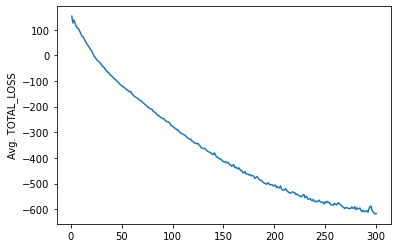

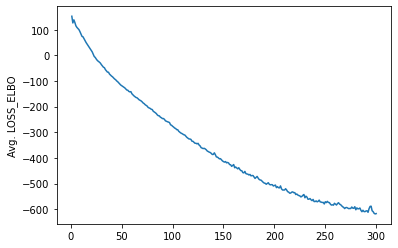

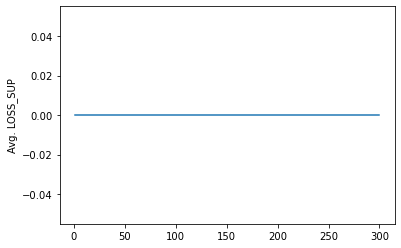

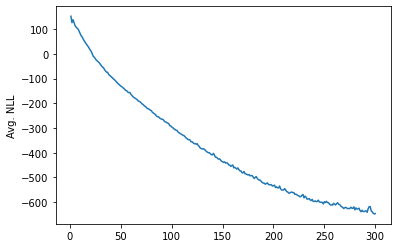

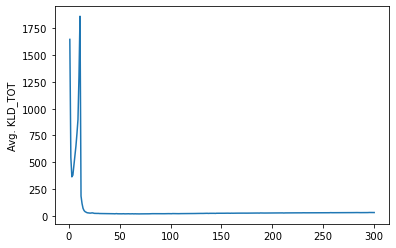

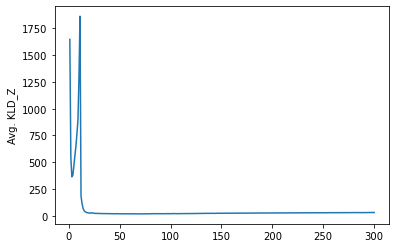

In [30]:
# Plots for losses
for col_name in df_train_metrics.columns:
    if "Avg. " in col_name:
        sns.lineplot(x=epochs_range,y=df_train_metrics[col_name])
        plt.show()

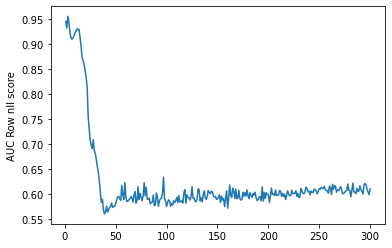

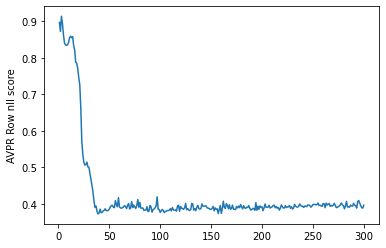

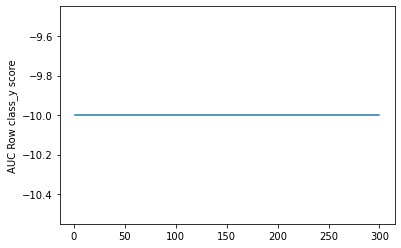

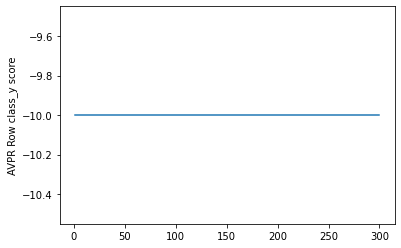

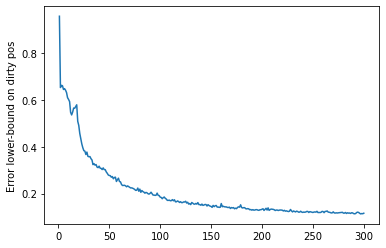

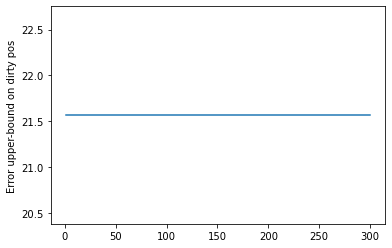

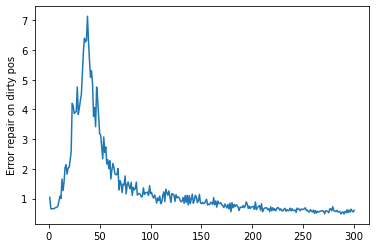

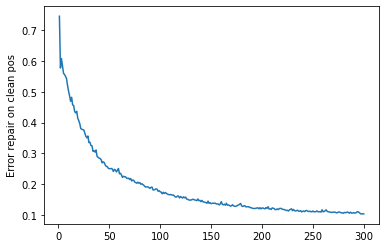

In [31]:
# Plots for classification and repair metrics
list_plot_custom = ["AUC Row nll score", "AVPR Row nll score", 
                    "AUC Row class_y score", "AVPR Row class_y score",
                    "Error lower-bound on dirty pos", "Error upper-bound on dirty pos",
                    "Error repair on dirty pos", "Error repair on clean pos"]

for col_name in list_plot_custom:
    sns.lineplot(x=epochs_range,y=df_train_metrics[col_name])
    plt.show()

## Plots Validation -- Losses

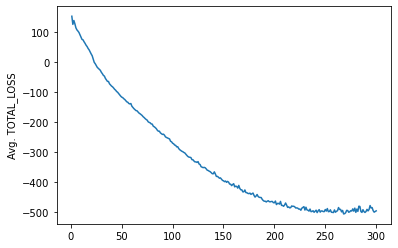

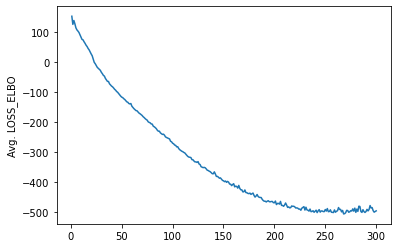

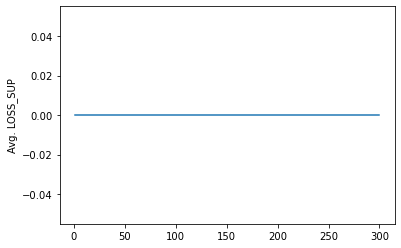

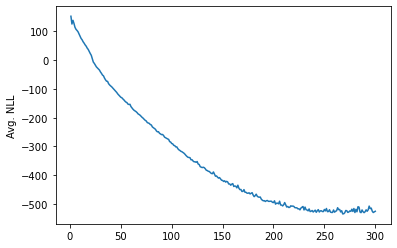

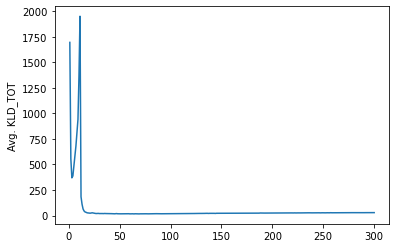

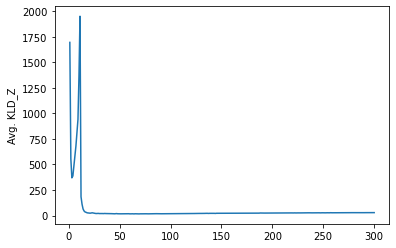

In [32]:
# Plots for losses
for col_name in df_valid_metrics.columns:
    if "Avg. " in col_name:
        sns.lineplot(x=epochs_range,y=df_valid_metrics[col_name])
        plt.show()

### Plot Test -- Losses

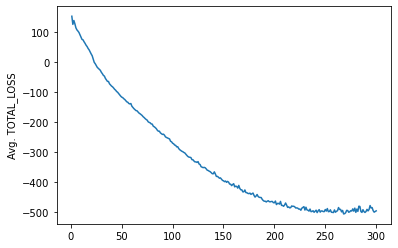

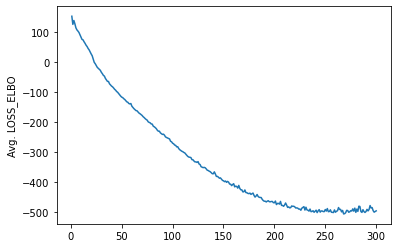

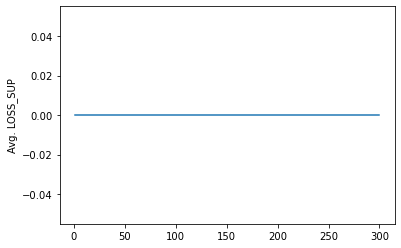

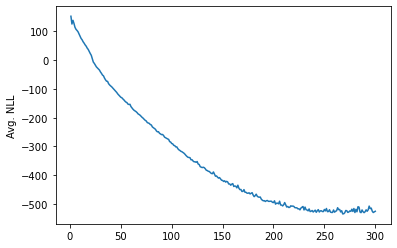

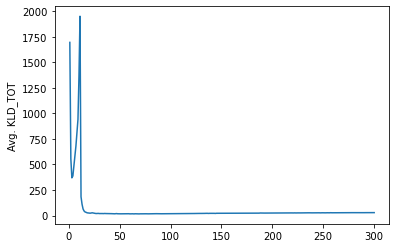

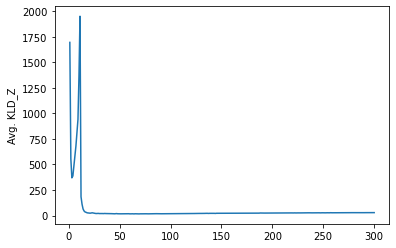

In [33]:
# Plots for losses
for col_name in df_test_metrics.columns:
    if "Avg. " in col_name:
        sns.lineplot(x=epochs_range,y=df_test_metrics[col_name])
        plt.show()

### Get Recons, Latent Space, etc

In [45]:
vae_p_params_xd, vae_q_params, vae_q_samples, _ = vae_mdl(X_train, y_targets=y_targets_mdl, repair_mode=True)
recons_train = vae_p_params_xd['recon']['x'].cpu().detach().numpy()
z_train_clean = vae_q_params['z']['mu'].detach().cpu().numpy()


In [46]:
# Show recon logvar
vae_p_params_xd['recon']['logvar_x'].exp()

tensor([0.0423], grad_fn=<ExpBackward>)

In [48]:
# Plot mu's and covariance's

z_train_mu = vae_q_params['z']['mu'].detach().cpu().numpy()
z_train_var = np.exp(vae_q_params['z']['logvar'].detach().cpu().numpy())

print("median of variances (per dim), clean: \n {} \n".format(np.median(z_train_var, axis=0)))
print("median of means (per dim), clean: \n {} \n".format(np.median(z_train_mu, axis=0)))


median of variances (per dim), clean: 
 [1.14739974e-04 3.90790589e-02 9.37294317e-05 3.88538502e-02
 2.52575672e-04 9.16283316e-05 1.14439899e-04 3.87029052e-02
 3.90838087e-02 3.88504937e-04 4.00669947e-02 6.41980369e-05
 1.01278958e-04 3.94178256e-02 1.92016043e-04] 

median of means (per dim), clean: 
 [-0.00087376  0.0030155   0.04103312  0.0042073   0.01569896  0.0141013
  0.00069697  0.00724895 -0.00228007  0.01365815 -0.00307335 -0.00433127
 -0.008092   -0.00328043 -0.01974491] 



### Recons

In [49]:
recon_imgs_train = recons_train.reshape(-1,28,20)*dataset_obj.cont_stds + dataset_obj.cont_means

In [50]:
dataset_obj.cont_means

154.0488358778626

In [51]:
dataset_obj.cont_stds

48.54248012196572

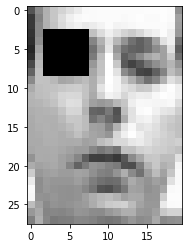

In [58]:
# Show image from train dataset

plt.imshow(x_train_orig[546], cmap="gray",)

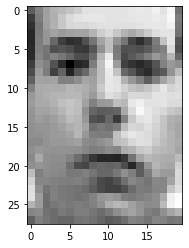

In [59]:
# Show image reconstruction from CVAE model

plt.imshow(np.around(recon_imgs_train[546]), cmap="gray", )

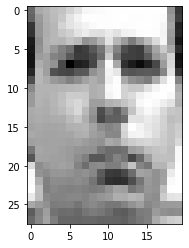

In [60]:
# Show image from train dataset

plt.imshow(x_train_orig[540], cmap="gray",)

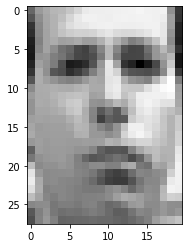

In [61]:
# Show image reconstruction from CVAE model

plt.imshow(np.around(recon_imgs_train[540]), cmap="gray", )

### Show Clean Datapoints at Random

y_noise: 0


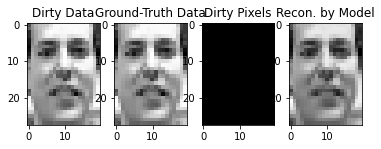

y_noise: 0


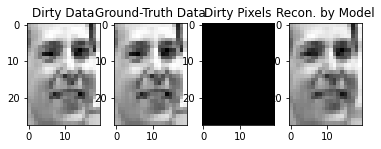

y_noise: 0


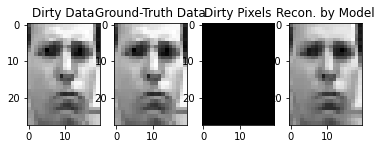

y_noise: 0


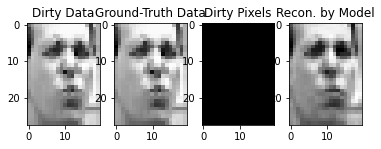

y_noise: 0


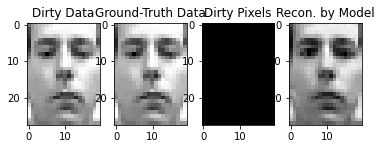

y_noise: 0


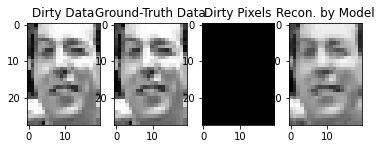

y_noise: 0


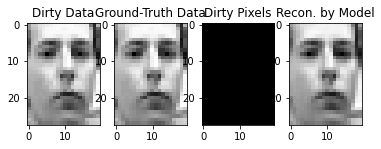

y_noise: 0


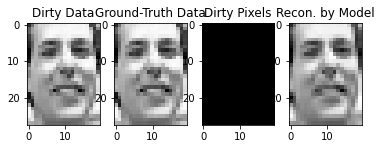

y_noise: 0


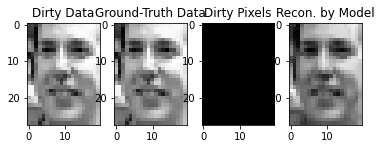

y_noise: 0


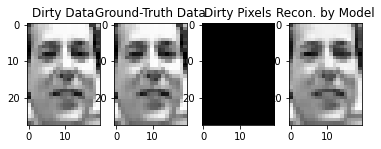

y_noise: 0


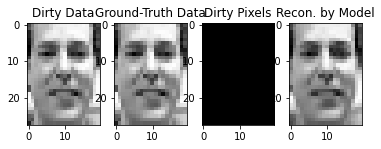

y_noise: 0


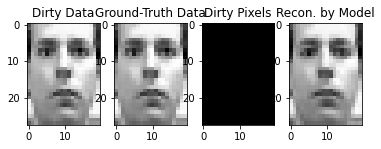

y_noise: 0


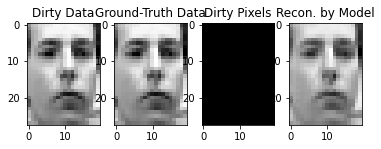

y_noise: 0


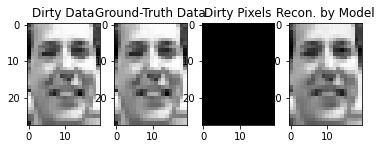

y_noise: 0


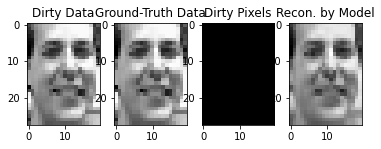

y_noise: 0


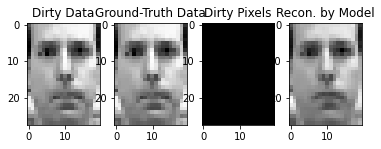

y_noise: 0


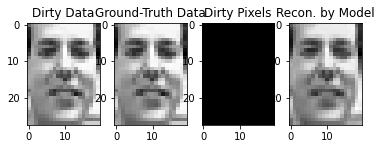

y_noise: 0


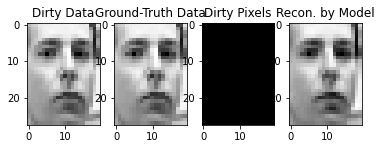

y_noise: 0


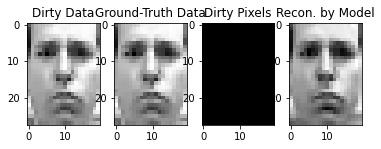

y_noise: 0


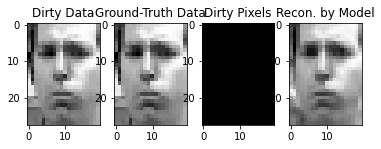

y_noise: 0


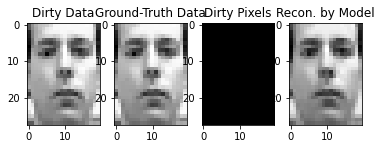

y_noise: 0


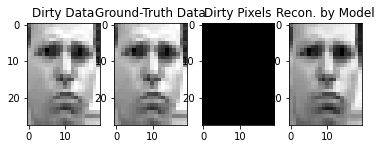

y_noise: 0


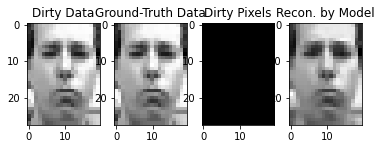

y_noise: 0


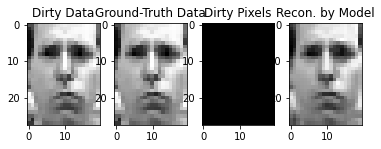

y_noise: 0


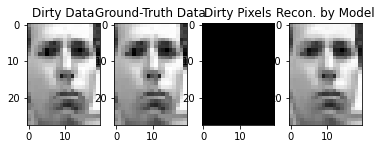

In [63]:
max_imgs_show = 25
y_noise_idxs_train = np.where(~y_noise_instance_train)[0]
some_idxs = np.random.permutation(y_noise_idxs_train)[:max_imgs_show]
# y_noise -- 1 if instance dirty; 0 if instance clean. (NOTE: inverted meaning in generative model)
    
for idx in some_idxs:
    print("y_noise: {}".format(int(y_noise_instance_train[idx])))
    fig, ax = plt.subplots(1,4)
    ax[0].imshow(x_train_orig[idx,...], cmap="gray", ) # vmin=0.0, vmax=1.0
    ax[0].set_title("Dirty Data")
    ax[1].imshow(x_train_clean_orig[idx,...], cmap="gray", ) # vmin=0.0, vmax=1.0
    ax[1].set_title("Ground-Truth Data")
    ax[2].imshow(y_noise_pixels_train[idx,...], cmap="gray", ) # vmin=0.0, vmax=1.0
    ax[2].set_title("Dirty Pixels")
    #ax[3].imshow(recon_imgs_train[idx,...], cmap="gray",) #  vmin=0.0, vmax=1.0
    ax[3].imshow(recon_imgs_train[idx,...], cmap="gray",) #  vmin=0.0, vmax=1.0
    ax[3].set_title("Recon. by Model")
    plt.show()


### Show Dirty Datapoints at Random

y_noise: 1


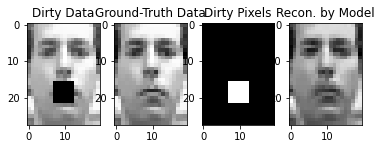

y_noise: 1


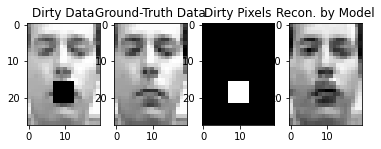

y_noise: 1


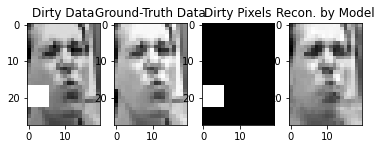

y_noise: 1


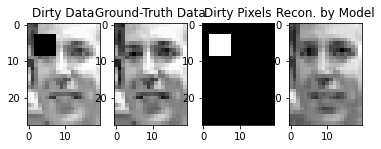

y_noise: 1


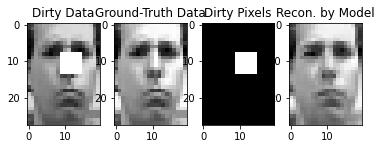

y_noise: 1


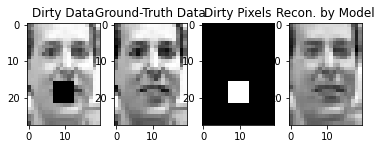

y_noise: 1


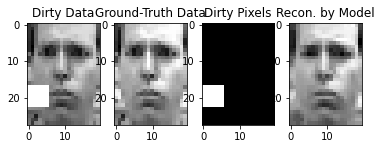

y_noise: 1


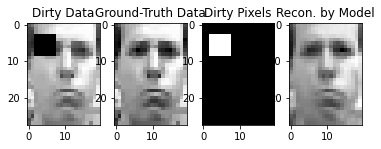

y_noise: 1


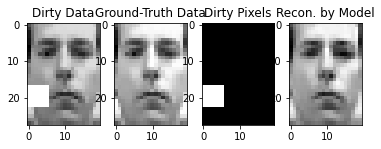

y_noise: 1


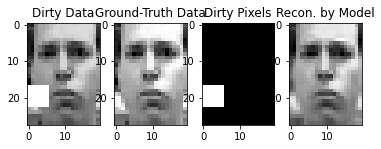

y_noise: 1


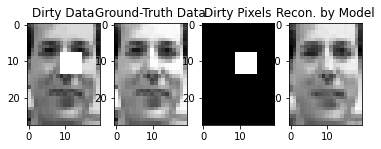

y_noise: 1


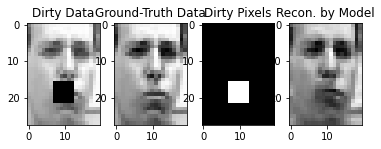

y_noise: 1


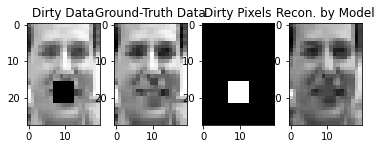

y_noise: 1


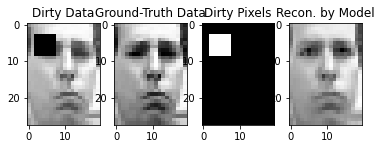

y_noise: 1


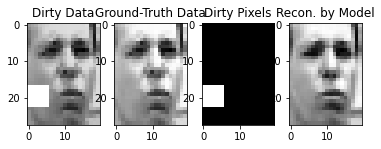

y_noise: 1


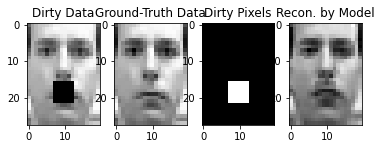

y_noise: 1


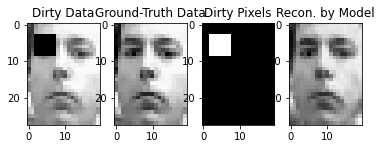

y_noise: 1


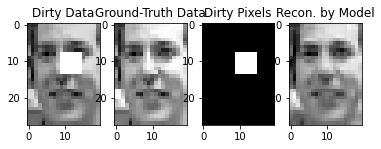

y_noise: 1


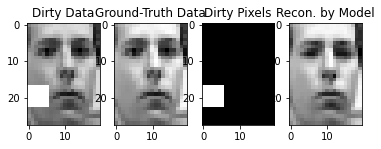

y_noise: 1


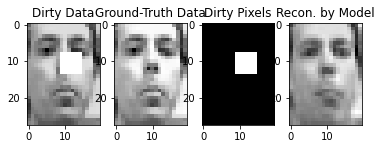

y_noise: 1


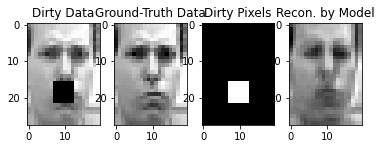

y_noise: 1


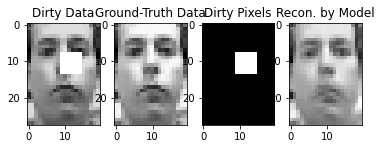

y_noise: 1


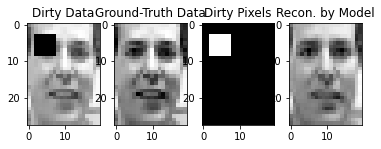

y_noise: 1


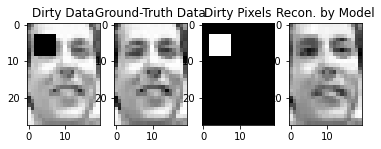

y_noise: 1


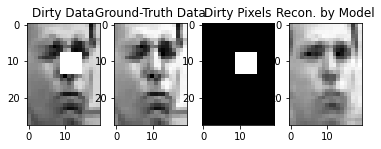

In [64]:
max_imgs_show = 25
y_noise_idxs_train = np.where(y_noise_instance_train)[0]
some_idxs = np.random.permutation(y_noise_idxs_train)[:max_imgs_show]
# y_noise -- 1 if instance dirty; 0 if instance clean. (NOTE: inverted meaning in generative model)
    
for idx in some_idxs:
    print("y_noise: {}".format(int(y_noise_instance_train[idx])))
    fig, ax = plt.subplots(1,4)
    ax[0].imshow(x_train_orig[idx,...], cmap="gray", ) # vmin=0.0, vmax=1.0
    ax[0].set_title("Dirty Data")
    ax[1].imshow(x_train_clean_orig[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
    ax[1].set_title("Ground-Truth Data")
    ax[2].imshow(y_noise_pixels_train[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
    ax[2].set_title("Dirty Pixels")
    ax[3].imshow(recon_imgs_train[idx,...], cmap="gray",) #  vmin=0.0, vmax=1.0
    #ax[3].imshow(recon_imgs_train[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
    ax[3].set_title("Recon. by Model")
    plt.show()



### Show per noise type images: y_noise_lists or y_noise_dict

Noise Tag: 0
Noise Indices: 
[932, 474, 203, 1513, 1003, 1530, 303, 546, 1071, 760, 429, 1418, 1083, 287, 1348, 1140, 330, 1386, 885, 331, 895, 33, 705, 698, 558, 1427, 843, 1193, 746, 867, 1500, 671, 1415, 1130, 1304, 129, 937, 1118, 1372, 422, 523, 261, 1397, 1152, 953, 1349, 271, 872, 928, 779, 173, 1166, 21, 454, 399, 1391, 894, 797, 561, 1145, 1081, 1195, 554, 1554, 1208, 1317, 253, 6, 670, 1390, 456, 1550, 1061, 1436, 1199, 1232, 1562, 1339, 1393, 681, 1213, 248, 1244, 424, 92, 350, 1485, 919, 1279, 225, 644, 552, 179, 1464, 355, 403, 25, 88, 1478, 852, 854, 1139, 909, 1503, 148, 348, 1157, 300, 1340, 688, 916, 436, 1337, 112, 956, 347, 724, 265, 356, 1137, 817, 619, 929, 962, 368, 335, 1205, 259, 1553, 689]
y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


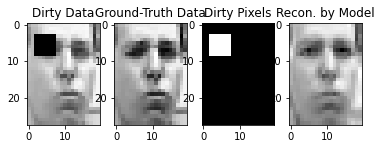

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


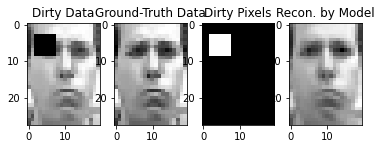

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


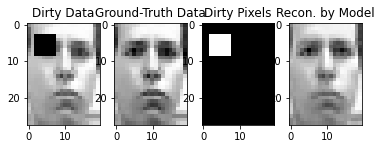

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


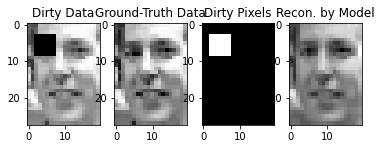

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


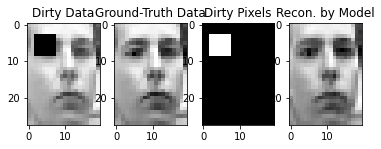

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


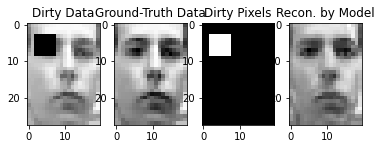

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


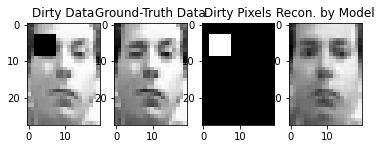

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


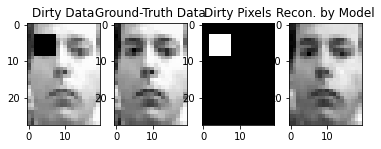

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


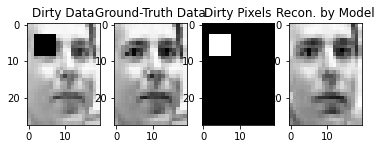

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


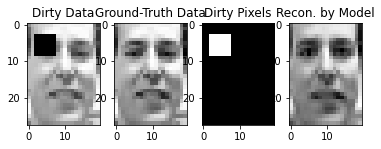







Noise Tag: 1
Noise Indices: 
[930, 1476, 650, 161, 45, 2, 1198, 1434, 616, 614, 150, 651, 162, 661, 1063, 100, 631, 1050, 328, 1128, 798, 1057, 1033, 1255, 384, 604, 756, 487, 816, 612, 1188, 493, 1214, 1223, 44, 1456, 636, 205, 164, 998, 1510, 295, 157, 773, 765, 1571, 8, 1266, 1173, 1442, 755, 1009, 1315, 1481, 396, 1286, 726, 1067, 1225, 250, 1566, 362, 800, 559, 1408, 483, 435, 841, 431, 70, 82, 514, 444, 34, 738, 234, 1169, 1074, 332, 570, 1020, 1264, 1399, 673, 1471, 1480, 397, 1298, 1398, 393, 1068, 499, 383, 116, 195, 196, 562, 281, 90, 1141, 1345, 285, 1184, 1191, 1330, 511, 305, 55, 1370, 473, 1552, 238, 278, 969, 1238, 1175, 732, 439, 402, 1319, 1308, 740, 188, 898, 596, 1116, 1343, 741, 1289, 211, 1196, 140, 1551, 1302, 1248, 1375, 730, 1052, 1377, 923, 1565, 1189, 1010, 450]
y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


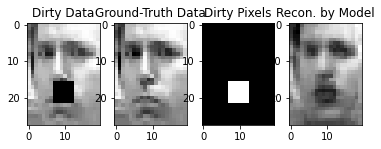

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


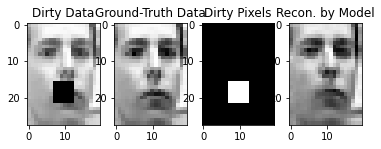

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


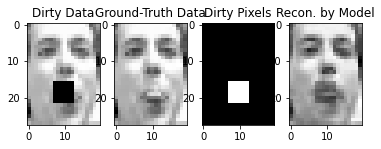

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


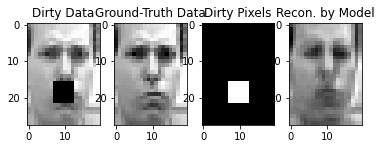

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


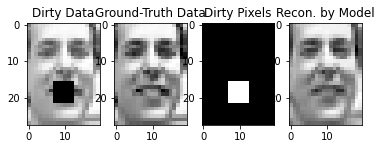

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


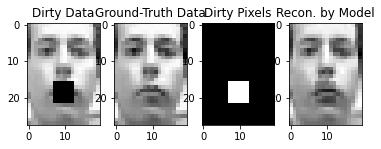

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


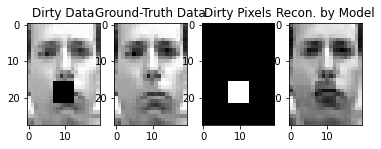

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


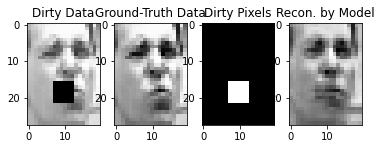

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


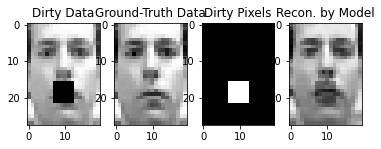

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


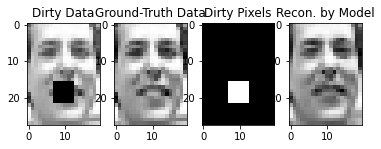







Noise Tag: 2
Noise Indices: 
[1004, 1093, 491, 252, 711, 1075, 1463, 68, 1369, 433, 158, 997, 375, 412, 1455, 1428, 597, 340, 7, 336, 538, 543, 390, 657, 500, 1371, 1096, 322, 957, 154, 10, 993, 13, 128, 497, 1546, 1406, 821, 121, 1262, 130, 1056, 676, 757, 634, 1328, 678, 1097, 1534, 708, 955, 795, 679, 943, 310, 587, 1525, 381, 859, 1219, 653, 857, 220, 57, 981, 451, 982, 845, 254, 411, 806, 582, 1030, 477, 1127, 298, 169, 42, 1462, 563, 1441, 547, 1103, 588, 663, 1294, 739, 759, 1338, 864, 703, 1438, 1320, 959, 617, 366, 938, 279, 1265, 1517, 319, 526, 1099, 96, 1007, 702, 472, 530, 1186, 230, 1104, 989, 822, 1569, 949, 1240, 1332, 975, 579, 1107, 1488, 1060, 1037, 625, 1494, 327, 1153, 379, 1300, 788, 176, 1344, 1496, 1042, 1439]
y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


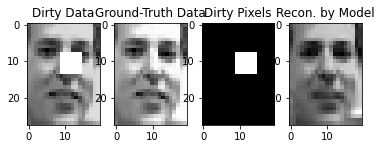

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


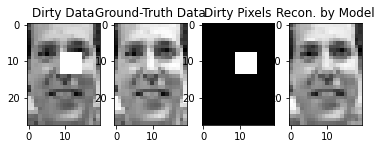

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


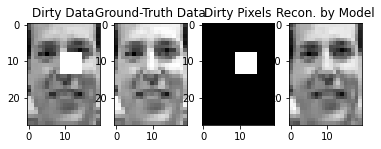

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


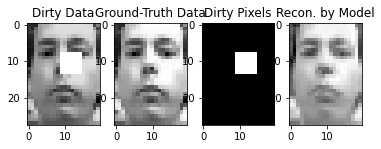

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


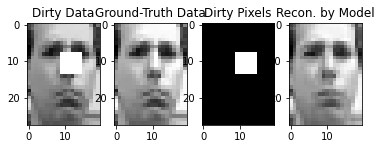

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


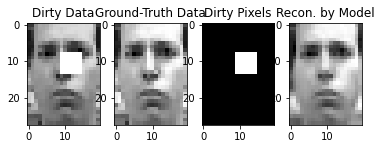

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


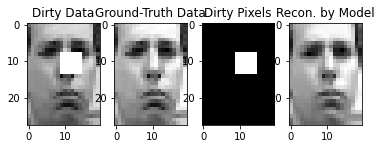

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


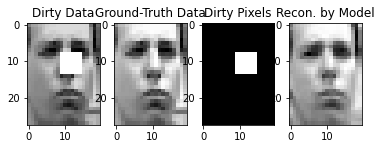

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


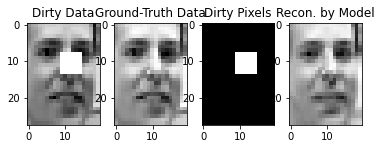

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


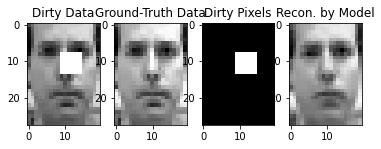







Noise Tag: 3
Noise Indices: 
[1079, 577, 476, 359, 312, 155, 1234, 388, 805, 231, 1498, 723, 1110, 1489, 633, 457, 308, 507, 1411, 697, 1365, 496, 1564, 1258, 525, 1101, 1172, 920, 181, 510, 1149, 1284, 27, 1417, 555, 1158, 413, 1201, 486, 802, 1549, 1402, 731, 1283, 437, 52, 245, 1251, 1453, 1531, 1380, 72, 753, 1495, 865, 288, 1492, 823, 660, 694, 1334, 1105, 1041, 210, 223, 520, 882, 110, 200, 1394, 1029, 835, 339, 301, 373, 296, 466, 1220, 1429, 1049, 1027, 1069, 1087, 896, 349, 1292, 907, 395, 1025, 1364, 1314, 830, 1414, 275, 601, 542, 191, 11, 1506, 446, 967, 360, 1072, 3, 40, 785, 808, 1450, 1121, 1293, 463, 610, 434, 803, 539, 479, 316, 1170, 1167, 1341, 700, 970, 1085, 971, 573]
y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


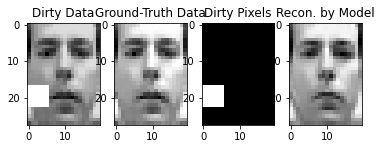

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


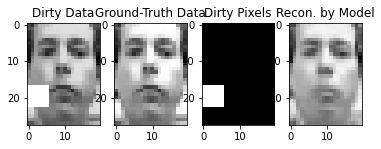

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


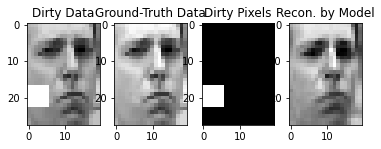

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


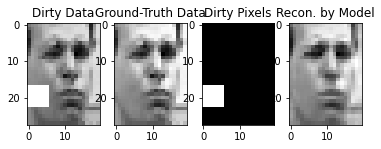

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


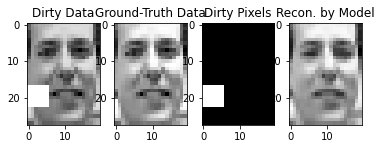

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


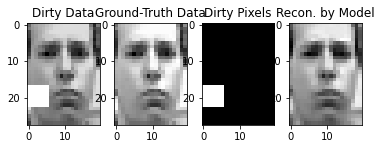

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


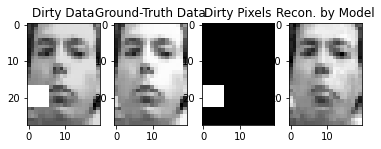

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


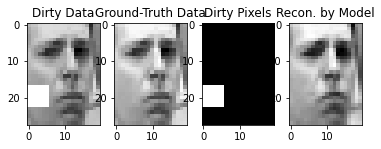

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


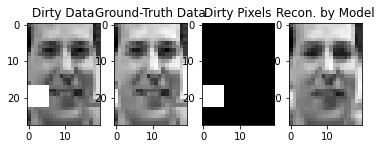

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


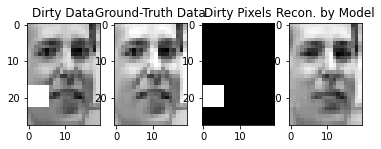

In [65]:
## show per noise type images: y_noise_lists or y_noise_dict

max_show_n = 10

for noise_key, noise_idxs in y_noise_dict_train.items():
    
    print("Noise Tag: {}".format(noise_key))
    print("Noise Indices: \n{}".format(noise_idxs))
    
    _selected_idxs = np.random.permutation(noise_idxs)[:max_show_n]
    
    for idx in _selected_idxs:
    
        print("y_class (clean): {} | y_noise: {} | y_noise_tag (noise type): {}".format(
            0, y_noise_instance_train[idx], noise_key)) # y_class_train[idx]
        fig, ax = plt.subplots(1,4)
        ax[0].imshow(x_train_orig[idx,...],cmap="gray")
        ax[0].set_title("Dirty Data")
        ax[1].imshow(x_train_clean_orig[idx,...],cmap="gray")
        ax[1].set_title("Ground-Truth Data")
        ax[2].imshow(y_noise_pixels_train[idx,...],cmap="gray")
        ax[2].set_title("Dirty Pixels")
        #ax[3].imshow(recon_imgs_train[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
        ax[3].imshow(recon_imgs_train[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
        ax[3].set_title("Recon. by Model")
        plt.show()
        
    print("\n\n\n\n\n")


### Show Latent Space

In [66]:
noised_rows = y_noise_instance_train
noised_rows_str = ["Inlier" if not row_val else "Outlier" for row_val in noised_rows]

#### PCA

In [67]:
from sklearn.decomposition import PCA

# Use underlying clean train data for representation
pca_2d_z = PCA(n_components=2) # PCA
pca_2d_z.fit(z_train_clean)

PCA(n_components=2)

In [68]:
pca_2d_z.explained_variance_

array([0.11450288, 0.09123819], dtype=float32)

In [69]:
z_train_pca2d_clean = pca_2d_z.transform(z_train_clean)

Text(0.5, 1.0, 'Latent Space Z (Projection to 2D) for a clean q(z|x)')

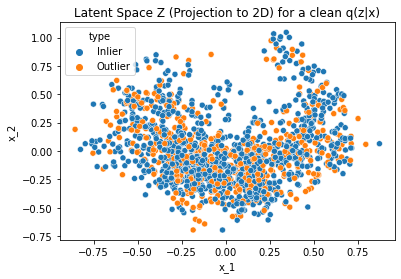

In [70]:
df_plot_z_pca2d_y1 = pd.DataFrame({"x_1": z_train_pca2d_clean[:,0], 
                                   "x_2": z_train_pca2d_clean[:,1], 
                                   "type": noised_rows_str})
sns.scatterplot(x="x_1",y="x_2",hue="type",data=df_plot_z_pca2d_y1)
plt.title("Latent Space Z (Projection to 2D) for a clean q(z|x)")

### Kernel PCA

In [79]:
from sklearn.decomposition import KernelPCA

# Use underlying clean train data for representation
kpca_2d_z = KernelPCA(n_components=2, kernel='rbf', degree=5)
kpca_2d_z.fit(z_train_clean)

KernelPCA(degree=5, kernel='rbf', n_components=2)

In [80]:
z_train_kpca2d_clean = kpca_2d_z.transform(z_train_clean)

Text(0.5, 1.0, 'Latent Space Z (Projection to 2D) for a clean q(z|x)')

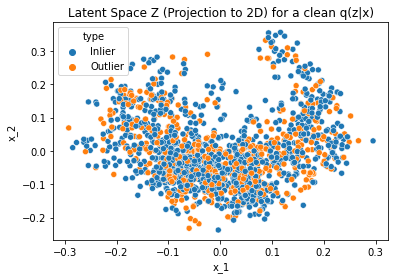

In [81]:
df_plot_z_kpca2d = pd.DataFrame({"x_1": z_train_kpca2d_clean[:,0], 
                                   "x_2": z_train_kpca2d_clean[:,1], 
                                   "type": noised_rows_str})
sns.scatterplot(x="x_1",y="x_2",hue="type",data=df_plot_z_kpca2d)
plt.title("Latent Space Z (Projection to 2D) for a clean q(z|x)")

#### T-SNE

In [83]:
from sklearn.manifold import TSNE

In [84]:
tsne_2d_z = TSNE(n_components=2, perplexity=250.0, n_iter=5000)
_z_all_2d = tsne_2d_z.fit_transform(z_train_clean)

In [85]:
_len_dataset = z_train_clean.shape[0]
z_train_tsne2d_clean = _z_all_2d

Text(0.5, 1.0, 'Latent Space Z (Projection to 2D) for a clean q(z|x)')

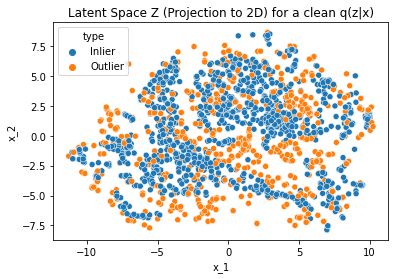

In [86]:
df_plot_z_tsne2d = pd.DataFrame({"x_1": z_train_tsne2d_clean[:,0], 
                                   "x_2": z_train_tsne2d_clean[:,1], 
                                   "type": noised_rows_str})
sns.scatterplot(x="x_1",y="x_2",hue="type",data=df_plot_z_tsne2d)
plt.title("Latent Space Z (Projection to 2D) for a clean q(z|x)")

### Approx. Log-Likelihood -- via IWAE (Importance Weighted AE Loss)

In [87]:
from repair_syserr_models.loss_utils import log_px_approx_eval

In [88]:
# TODO: insert option for cuda vs. cpu !!
x_inputs = X_train.cuda()
vae_mdl.cuda();


In [89]:
with torch.autograd.profiler.profile(use_cuda=True, profile_memory=True) as prof:

    # log p(x|y) evaluation, for both y=1 and y=0
    elbo_iwae = log_px_approx_eval(vae_mdl,
                                   dataset_obj,
                                   x_inputs,
                                   k_samples=250,
                                   y_comps=False,
                                   batch_size=128, 
                                   y_targets=y_targets_mdl.cuda(), 
                                   repair_mode=True)

    # to clear GPU Mem -- if used.
    log_px_est = elbo_iwae.clone().cpu()
    
    del elbo_iwae
    torch.cuda.empty_cache()


Compute Progress: 100%|█████████████████████████████████████████████| 13/13 [00:00<00:00, 37.44it/s]


In [90]:
# print(prof)

In [91]:
arrs_elbo_iwae = np.concatenate([log_px_est, y_noise_instance_train.reshape(-1,1)], axis=1)

df_elbo_iwae = pd.DataFrame(arrs_elbo_iwae, columns=["log_px", "noise_label"])
df_elbo_iwae["noise_label"] = df_elbo_iwae["noise_label"].apply(lambda x: "dirty" if x==1 else "clean")

In [92]:
df_elbo_iwae

,log_px,noise_label
0,533.192749,clean
1,561.088135,clean
2,-1194.121094,dirty
3,-1471.356812,dirty
4,470.724304,clean
...,...,...
1567,774.114441,clean
1568,644.804626,clean
1569,-1398.712402,dirty
1570,726.191406,clean


In [93]:
def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)


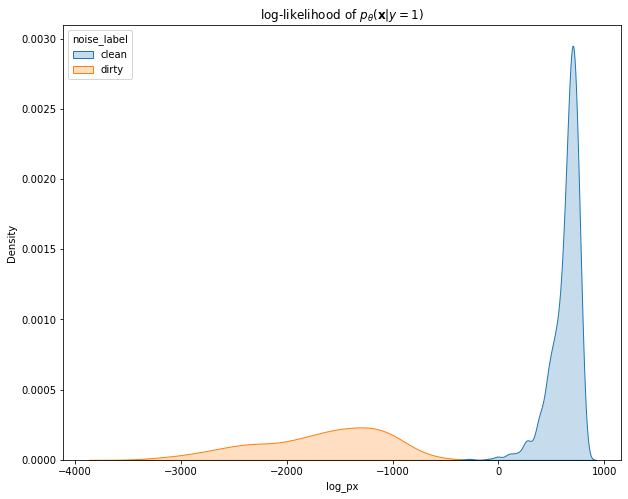

In [94]:
fig, axes = plt.subplots(1,1, figsize=(10,8))

sns.kdeplot(ax=axes, data=df_elbo_iwae, x="log_px", hue="noise_label", fill=True, legend=True)

axes.set_title("log-likelihood of $p_{\\theta}(\mathbf{x}|y=1)$")
move_legend(axes, "upper left")


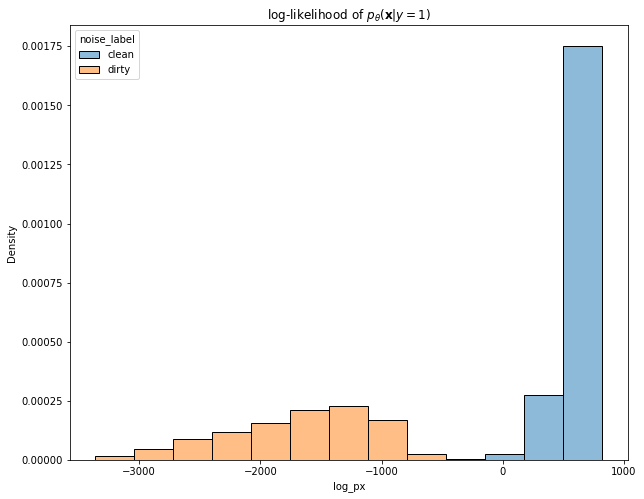

In [95]:
fig, axes = plt.subplots(1,1, figsize=(10,8))

sns.histplot(ax=axes, data=df_elbo_iwae, x="log_px", hue="noise_label", legend=True, stat="density")
axes.set_title("log-likelihood of $p_{\\theta}(\mathbf{x}|y=1)$")
move_legend(axes, "upper left")


In [96]:
def epdf(xs, bins):
    xmin, xmax = np.inf, -np.inf
    for xi in xs:
        xmin = min(xmin, np.nanmin(xi))
        xmax = max(xmax, np.nanmax(xi))
    bin_range = (xmin, xmax)
    bins = np.lib.histograms.histogram_bin_edges(np.concatenate(xs), bins, bin_range)
    tops = []
    for xi in xs:
        m, _ = np.histogram(xi, bins, density=True)
        tops.append(m.astype(float))
    return tops, bins


In [97]:
tops, bin_edges = epdf([log_px_est.numpy().flatten()[~y_noise_instance_train], log_px_est.numpy().flatten()[y_noise_instance_train]], 25)
top_model, top_data = tops[0], tops[1]

In [98]:
# Earth Movers Distance (EMD)
np.sum(np.abs(top_model - top_data))

0.011945189229789002

In [99]:
def histogram_intersection(h1, h2, bins):
    bins = np.diff(bins)
    sm = 0
    for i in range(len(bins)):
        sm += min(bins[i]*h1[i], bins[i]*h2[i])
    return sm

In [100]:
# Area of intersection between the two histograms
histogram_intersection(tops[0], tops[1], bin_edges)

0.0